# Finite Difference Method

Some cells were not run in order. Will come back to make sure everything works out when do 'run all'later.

In [1]:
import numpy as np
import scipy.stats as si
from scipy.sparse import diags
from scipy.linalg import solve_triangular
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize

We discretise the solution space
$$
0 \leq t \leq T, r^{-} \leq r \leq r^{+}
$$
using a grid of $m$ space steps, $\Delta r$ apart, and $n$ time steps, $\Delta t$ apart, where
$$
\Delta r=\frac{\left(r^{+}-r^{-}\right)}{m} \text { and } \Delta t=T / n
$$

A general point on the grid has position
$$
(r, t)=\left(r^{-}+i \Delta r, j \Delta t\right)
$$
where
$$
0 \leq i \leq m \text { and } 0 \leq j \leq n
$$

We approximate the solution $V$ at a gridpoint by $U$, where,
$$
V\left(r^{-}+i \Delta r, j \Delta t\right) \approx U_{i}^{j} .
$$

In [2]:
# Grid parameters
r_min, r_max = 0.03, 0.20
c_min, c_max = -0.04, 0.04
N, M = 1000, 100  # N = 1000, M = 100

# Market parameters
sigma, T = 0.01, 10

# Setup of grids
dt = T/N
dr = (r_max - r_min)/M
r = np.linspace(r_min, r_max, M+1)
t = np.linspace(0, T, N+1)

In [3]:
# Satisfy the CFL condition -> Stable
print(c_max * dt <= dr)

True


$$
\frac{U_{i}^{j}-U_{i}^{j-1}}{\Delta t}+c\left(r, V_{r}\right) \frac{1}{\Delta r}\left\{\begin{array}{ll}
U_{i+1}^{j}-U_{i}^{j} & \text { if } c>0 \\
U_{i}^{j}-U_{i-1}^{j} & \text { if } c<0
\end{array}\right\}-\left(r_{min}+i \Delta r\right) U_{i}^{j}=0
$$

$$
 U_{i}^{j-1}=\left(1-\left(r_{min}+i \Delta r\right) \Delta t\right) U_{i}^{j}+c\left(r, V_{r}\right) \frac{\Delta t}{\Delta r} \begin{cases}U_{i+1}^{j}-U_{i}^{j} & \text { if } c>0  \\ U_{i}^{j}-U_{i-1}^{j} & \text { if } c \leq 0 .\end{cases}
$$
, stabel if $\left|c\left(r, V_{r}\right)\right| \Delta t \leq \Delta r$

Description for $c(r,V_r)$ ois complicated. In summary,

1. Check if Minima($
U_{i}^{j} \leq U_{i-1}^{j} \text { and } U_{i}^{j} \leq U_{i+1}^{j}
$), $c\left(r, V_{r}\right)=0.$
2. eliff Maxima($
U_{i}^{j} \geq U_{i-1}^{j} \text { and } U_{i}^{j} \geq U_{i+1}^{j}
$), $$
c\left(r, V_{r}\right)= \begin{cases}c_{max} & \text { if } c_{max}\left(U_{i+1}^{j}-U_{i}^{j}\right) \leq c_{min}\left(U_{i}^{j}-U_{i-1}^{j}\right) \\ c_{min} & \text { if } c_{max}\left(U_{i+1}^{j}-U_{i}^{j}\right)>c_{min}\left(U_{i}^{j}-U_{i-1}^{j}\right)\end{cases}
$$
3. else: $$ c\left(r, V_{r}\right)= \begin{cases}c_{max}\left(r_{min}+i \Delta r\right) & \text { if } U_{i+1}^{j}-U_{i-1}^{j}<0 \\ c_{min}\left(r_{min}+i \Delta r\right) & \text { if } U_{i+1}^{j}-U_{i-1}^{j}>0\end{cases}.$$

Address the boundary values appropriately




In [4]:
def c(u_ij, M):

  """
  Compute the c(r, V_r) vector given (u_j) vector
  """

  u_minus_1 = u_ij[0:-2]
  u = u_ij[1:-1]
  u_plus_1 = u_ij[2:M+1]

  # initialise the c matrix called c_int, and modify the boundary values
  c_ans = 100 * np.ones(M+1)
  c_ans[0] = c_max if (u_ij[1] - u_ij[0])/dr < 0 else 0
  c_ans[-1] = c_min if (u_ij[-1] - u_ij[-2])/dr >0 else 0

  # compute the (c_i)j values (except at c_0 and c_n boundaries)

  # Numpy version of : If Minima->0, elif maxima either c_max or c_min, else either c_max or c_min

  c = np.where((u_minus_1>u) & (u<u_plus_1),
               0,
               np.where((u_minus_1<u) & (u>u_plus_1) & (c_max*(u_plus_1-u)<= c_min*(u-u_minus_1)),
                        c_max ,
                        np.where((u_minus_1<u) & (u>u_plus_1) & (c_max*(u_plus_1-u)> c_min*(u-u_minus_1)),
                                 c_min ,
                                 np.where(u_plus_1-u_minus_1 < 0 ,
                                          c_max ,
                                          c_min))))
  c_ans[1:-1] = c

  return c_ans


def right_term(u_ij, c, M ,N):

   """
   Compute the right term of the RHS of the main iterative equation
   """

   dt = T/N
   dr = (r_max - r_min)/M

   u_minus_1 = u_ij[0:-2]
   u = u_ij[1:-1]
   u_plus_1 = u_ij[2:M+1]

   # Upwind scheme term

   upwind = np.zeros(M+1)
   # Modify the boundaries term
   upwind[0] = u_ij[1]-u_ij[0]
   upwind[-1] = u_ij[-1]-u_ij[-2]

   # The rest of the upwind term
   check = np.where(c(u_ij, M)[1:-1] > 0, u_plus_1 - u, u - u_minus_1 )
   upwind[1:-1] = check


   # Compute the right hand side of the equation
   right_term = (dt/dr) * np.multiply(c(u_ij, M), upwind)

   return right_term



In [ ]:
# u_ij = np.random.rand(101)
# print(u_ij)
# print(c(u_ij))
# print(right_term(u_ij, c))

$$V_{\text{best-case}} = -(-V)_{\text{worst-case}}.$$

Reminder:
$$
 U_{i}^{j-1}=\left(1-\left(r_{min}+i \Delta r\right) \Delta t\right) U_{i}^{j}+c\left(r, V_{r}\right) \frac{\Delta t}{\Delta r} \begin{cases}U_{i+1}^{j}-U_{i}^{j} & \text { if } c>0  \\ U_{i}^{j}-U_{i-1}^{j} & \text { if } c \leq 0 .\end{cases}
$$
, stabel if $\left|c\left(r, V_{r}\right)\right| \Delta t \leq \Delta r$


$$U^{j-1} = \text{left term}(U^{j}) + \text{right term}(U^{j})$$

In [5]:
# Payoff for ZCB
u_vec = np.ones(M+1)


# PDE solver for worst and best case scenarios
def pde_solver(u, c, T, M, N, worst = True):

  r = np.linspace(r_min, r_max, M+1)
  t = np.linspace(0, T, N+1)
  dt = T/N

  # For best case
  if worst == False:
    u = -u

  # For storing the values at different times
  U = np.zeros((M+1, N+1))
  U[:,N] = u

  #Backward induction
  for j in reversed(range(N)):
    left_term = np.multiply((1 - r*dt), u)
    u = left_term + right_term(u, c, M, N)
    U[:,j] += u

  return U if worst else -U


#print(pde_solver(u_vec, c))
#print(pde_solver(u_vec, c, worst = False))

In [ ]:
r = np.linspace(r_min, r_max, M+1)
Ns = [10, 100,500, 1000, 1200]
# Ms = [10, 100, 1000]

for N in Ns:
  dt = T/N
  print("N is "+ str(N))
  print(c_max * dt <= dr)

N is 10
False
N is 100
False
N is 500
True
N is 1000
True
N is 1200
True


In [ ]:
# Error exploration --> it seems that varying grid size can slightly change your answers
Ns = [500,1000,1200]
for N in Ns:
  print(pde_solver(u_vec, c, 10, M,N)[18,0])

0.17244895813000563
0.17279558838828976
0.17285333765383556


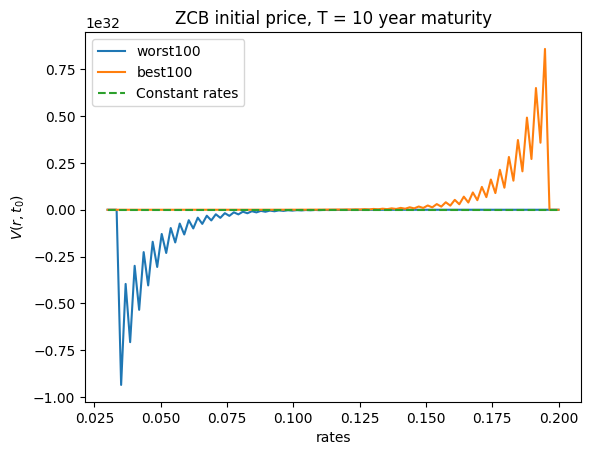

In [7]:
# Plot to see the curve
# Check stability by varying M and N

r = np.linspace(r_min, r_max, M+1)
Ns = [100]
for N in Ns:
  plt.plot(r, pde_solver(u_vec, c, 10, M,N)[:,0], label = "worst" + str(N))
  plt.plot(r, pde_solver(u_vec, c, 10,M,N, worst = False)[:,0], label = "best" + str(N))

plt.plot(r,np.exp(-r*T),linestyle ='--', label= "Constant rates" )
plt.xlabel("rates")
plt.ylabel("$V(r,t_0)$")
plt.title("ZCB initial price, T = 10 year maturity")
# plt.plot(t, u_vec)
# plt.legend(["Worst case", "Best case", "Constant rates"])
plt.legend()
#plt.show()
plt.savefig('zcb_10y_unstable.png')

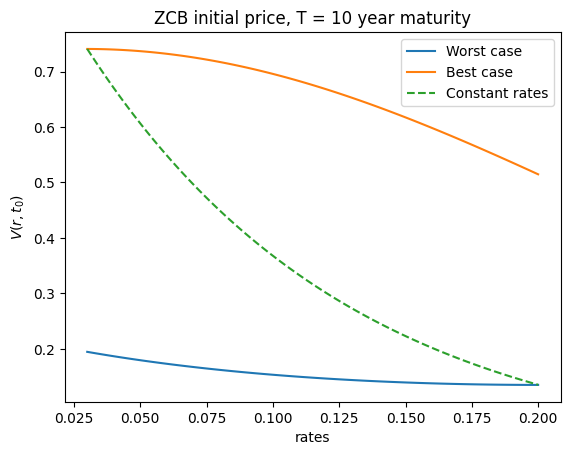

In [6]:
# Plot to see the curve
# Check stabikity by varying M and N

r = np.linspace(r_min, r_max, M+1)


plt.plot(r, pde_solver(u_vec, c, 10, M,N)[:,0])
plt.plot(r, pde_solver(u_vec, c, 10,M,N, worst = False)[:,0])
plt.plot(r,np.exp(-r*T),linestyle ='--' )
plt.xlabel("rates")
plt.ylabel("$V(r,t_0)$")
plt.title("ZCB initial price, T = 10 year maturity")
# plt.plot(t, u_vec)
plt.legend(["Worst case", "Best case", "Constant rates"])
plt.show()
#plt.savefig('zcb_10y_t0.png')

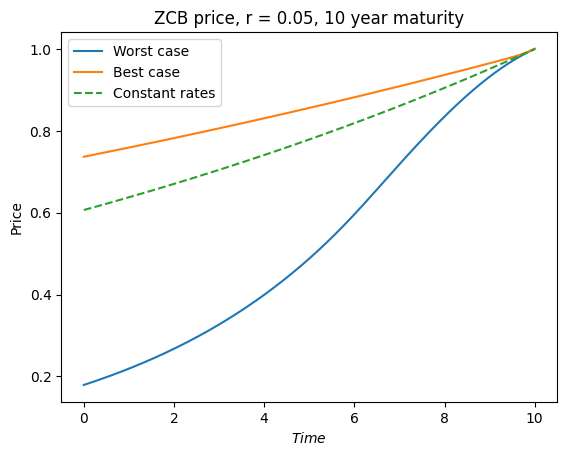

0.5572822550291141


In [7]:
# Result over time at a specified r say r = 0.05 --> at row 12

T =10
t = np.linspace(0, T, N+1)

plt.plot(t, pde_solver(u_vec, c, 10, M, N)[12,:])
plt.plot(t, pde_solver(u_vec, c, 10,  M, N,worst = False)[12,:])
plt.plot(t,np.exp(-0.05*t[::-1]),linestyle ='--' )
plt.xlabel("$Time$")
plt.ylabel("Price")
plt.title("ZCB price, r = 0.05, 10 year maturity")

plt.legend(["Worst case", "Best case", "Constant rates"])
plt.show()
#plt.savefig('zcb_10y_fixed_r.png')

# print the initial spread
print(pde_solver(u_vec, c, 10, M, N,worst = False)[12,0] - pde_solver(u_vec, c, 10,M, N,)[12,0])

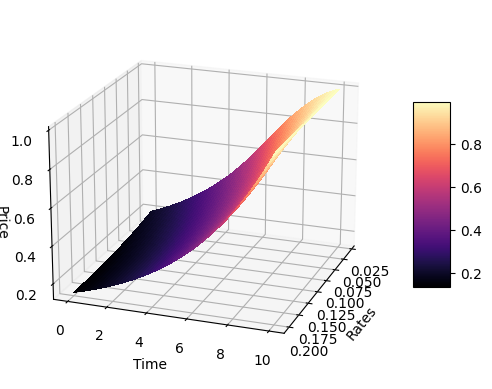

In [ ]:
# Plotting a surface

r = np.linspace(r_min, r_max, M+1)
t = np.linspace(0, T, N+1)

r, t = np.meshgrid(r, t)
U = pde_solver(u_vec, c, T, M, N,).transpose()


# print(t)
# print(r)
# print(U)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(r, t, U, cmap='magma', linewidth=0, antialiased=False)

# Add customizations
#ax.set_title('ZCB Worst Price Surface Plot')
ax.set_ylabel('Time')
ax.set_xlabel('Rates')
ax.set_zlabel('Price', labelpad=0.1)
ax.view_init(elev=20, azim=20)
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()
#plt.savefig('zcb_suface.png')

$$V^{-}\left(t, S_{t}, \lambda_{1}, \ldots, \lambda_{m}\right)
 =\max _{\lambda_1,\ldots,\lambda_m}\left(\inf _{P \in \mathcal{P}} \mathbb{E}_{t}^{P}\left[\sum_{i=1}^{N} C_{i} \mathrm{e}^{-\int_{t}^{T_{i}} \bar{r}(\tau) d \tau} + \sum_{j=1}^{N} \lambda_{j}D_{j} \mathrm{e}^{-\int_{t^{\prime}_j}^{T_{j}} \bar{r}(\tau) d \tau}\right]-\sum_{j=1}^{m} \lambda_{j} P_{j}\right)$$

 $$V^{+}\left(t, S_{t}, \lambda_{1}, \ldots, \lambda_{m}\right)
 =\min _{\lambda_1,\ldots,\lambda_m}\left(\sup _{P \in \mathcal{P}} \mathbb{E}_{t}^{P}\left[\sum_{i=1}^{N} C_{i} \mathrm{e}^{-\int_{t}^{T_{i}} \bar{r}(\tau) d \tau} + \sum_{j=1}^{N} \lambda_{j}D_{j} \mathrm{e}^{-\int_{t^{\prime}_j}^{T_{j}} \bar{r}(\tau) d \tau}\right]-\sum_{j=1}^{m} \lambda_{j} P_{j}\right)$$


 ### Example: We hedge a 5 year zero-coupon bond, with principal 1, with a 1 year zero-coupon bond, with principal 1 and market price 0.905. The spot short-term interest rate is 10%. The interest rate bounds are 3% and 20% and the growth rate is bounded by -4% pa and 4% pa.

In [8]:
# Hedging with one ZCB

# Payoff for the 5 year ZCB hedged with 1y zcb with current price of 0.905, short term rate = 10

u_vec = np.ones(M+1)
T = 5

dr = (r_max - r_min)/M

# PDE solver for worst and best case scenarios
def pde_solver_hedge(u, c, M, N ,T,lamb, worst = True):

  r = np.linspace(r_min, r_max, M+1)
  t = np.linspace(0, T, N+1)
  dt = T/N

  # For best case
  if worst == False:
    u = -u
    lamb = -lamb

  # For storing the values at different times
  U = np.zeros((M+1, N+1))
  # Adding the payoff
  U[:,N] = u
  # Adding the hedging instrument fixed cash flow (dependent on lamb value)
  U[:,200] = lamb* np.ones(M+1)

  #Backward induction
  for j in reversed(range(N)):
      left_term = np.multiply((1 - r*dt), U[:,j+1])
      U[:,j] += left_term + right_term(U[:,j+1], c, M, N)  # gotta add the payoff from the hedging instrument here I think

  return U if worst else -U


#print(pde_solver(u_vec, c))
#print(pde_solver(u_vec, c, worst = False))

In [ ]:
# Checked that the results match with Epstein
# Notice that the worst case hedge will indeed give highest worst case price and best case hedge will give lowest worst case price

print(pde_solver_hedge(u_vec, c,M, N,5,lamb = -2.044)[42,0] - (-2.044*0.905))
print(pde_solver_hedge(u_vec, c,M, N , 5, lamb = -2.044, worst= False)[42,0] - (-2.044*0.905))

port3 = pde_solver_hedge(u_vec, c,M, N , T=5, lamb = -2.407)[42,:] - (-2.407*0.905)*np.ones(N+1)
print(port3[0])
#plt.plot(t,port)

port4 = pde_solver_hedge(u_vec, c,M, N , T=5, lamb = -2.407, worst= False)[42,:] - (-2.407*0.905)*np.ones(N+1)
#plt.plot(t,port2)
print(port4[0])

0.4454227337387837
0.7750739342106163
0.4447259242582433
0.7741426351780998


In [ ]:
# Careful minimizer for best case and maximizer for worst case

# Define the objective function
def minimiser(lamb):  # for best case
    return pde_solver_hedge(u_vec, c, M, N ,5, lamb, worst = False)[42,0] - lamb * 0.905

def maximiser(lamb):  # for worst case
    return -pde_solver_hedge(u_vec, c,M, N , 5 , lamb)[42,0] + lamb * 0.905

# Set the initial guess
x0 = -1.5

# Bounds
bounds = ((-10, 10),)

# Minimize the function
result = minimize(minimiser, x0, bounds = bounds)
result2 = minimize(maximiser, x0, bounds = bounds)

# Print the result
print(result)
print(result2)

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 0.7741426020242126
        x: [-2.405e+00]
      nit: 9
      jac: [-5.529e-06]
     nfev: 32
     njev: 16
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: -0.44542273377376196
        x: [-2.044e+00]
      nit: 6
      jac: [ 2.509e-06]
     nfev: 14
     njev: 7
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>


## We hedge a 4 year zero-coupon bond, with principal 1, with zero coupon bonds, with principal 1. The spot short-term interest rate is 6%. The interest rate bounds are 3% and 20% and the growth rate is bounded by -4% pa and 4% pa.

In [9]:
# Grid parameters
r_min, r_max = 0.03, 0.20
c_min, c_max = -0.04, 0.04
N, M = 1000, 100  # N = 1000, M = 100

# Market parameters
sigma, T = 0.01, 4

# Setup of grids
dt = T/N
dr = (r_max - r_min)/M
r = np.linspace(r_min, r_max, M+1)
t = np.linspace(0, T, N+1)

Example: We hedge a 4 year zero-coupon bond, with principal 1, with zerocoupon bonds, with principal 1. These hedging bonds are shown in Table 4.1. The spot short-term interest rate is $6 \%$. The interest rate bounds are $3 \%$ and $20 \%$ and the growth rate is bounded by $-4 \%$ pa and $4 \%$ pa.



|Hedging bond |Maturity (yrs)|Market price|
| -------- | ------- | ------- |
|Z₁|0.5|0.97|
|Z₂|1|0.933|
|Z₃|2|0.868|
|Z₄|3|0.805|
|Z₅|5|0.687|
|Z₆|7|0.579|


In [10]:
def index_time_conv(list_t, T):
  ans = []
  dt = T/N
  for i in list_t:
    ans.append(int(round(i/dt)))

  return ans

def index_rate_conv(r):

  dr = (r_max - r_min)/M

  return round((r-r_min)/dr)

T=7
dt = T/N
maturity_times = [0.5,1,2,3,5,7,4]
print(index_time_conv(maturity_times, T)[:-1])

r = 0.06
print(index_rate_conv(r))

[71, 143, 286, 429, 714, 1000]
18


In [ ]:
# Satisfy the CFL condition -> Stable
print(c_max * dt <= dr)

True


In [11]:
# Payoff for the 4 year ZCB hedged with the prices listed above

u_vec = np.ones(M+1)
T = 7
maturity_times = [0.5,1,2,3,5,7,4]  # the last element for the main bond; otherwise, hedging bonds
market_prices = np.array([0.97,0.933,0.868,0.805,0.687,0.579])
dr = (r_max - r_min)/M

# PDE solver for worst and best case scenarios
def pde_solver_hedge(u, c, T,lambs , worst = True):

  r = np.linspace(r_min, r_max, M+1)
  t = np.linspace(0, T, N+1)
  dt = T/N

  # For best case
  if worst == False:
    u = -u
    lambs = -lambs

  # For storing the values at different times
  U = np.zeros((M+1, N+1))
  # Adding the payoff
  time_index = index_time_conv(maturity_times, T)
  #main_time_index = time_index[-1]
  U[:,time_index[-1]] = u

  # Adding the hedging instrument fixed cash flow (dependent on lamb value)
  for i in range(len(lambs)):
    U[:,time_index[i]] = lambs[i]* np.ones(M+1)

  #Backward induction
  for j in reversed(range(N)):
    left_term = np.multiply((1 - r*dt), U[:,j+1])
    U[:,j] += left_term + right_term(U[:,j+1], c, M,N)  # gotta add the payoff from the hedging instrument here I think

  return U if worst else -U


#print(pde_solver(u_vec, c))
#print(pde_solver(u_vec, c, worst = False))

In [12]:
# Careful minimizer for best case and maximizer for worst case
market_bid = np.array([0.97,0.933,0.868,0.805,0.667,0.579])
market_ask = np.array([0.97,0.933,0.868,0.805,0.707,0.579])
market_price = np.array([0.97,0.933,0.868,0.805,0.687,0.579])

# Define the objective function
def minimiser(lambs):  # for best case
    cost = np.dot(lambs, market_ask) if lambs[5] > 0 else np.dot(lambs, market_bid)
    return pde_solver_hedge(u_vec, c, 7, lambs, worst = False)[18,0] -  cost

def maximiser(lambs):  # for worst case
    cost = np.dot(lambs, market_ask) if lambs[5] > 0 else np.dot(lambs, market_bid)
    return -pde_solver_hedge(u_vec, c, 7, lambs)[18,0] + cost
# Set the initial guess
x0 = np.array([0.001,-0.01,0.1,-0.6,-0.4,0.001])

# Bounds
bounds = ((-1, 1),)

# Minimize the function
result = minimize(minimiser, x0, bounds = bounds)
#result2 = minimize(maximiser, x0, bounds = bounds)

# Print the result
print(result)
#print(result2)

  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: 0.7680988482371629
        x: [ 2.771e-03 -1.365e-02  8.408e-02 -6.362e-01 -4.619e-01
            -7.485e-05]
      nit: 5
      jac: [-4.393e-03 -9.718e-03 -1.102e-02  4.735e-03  4.788e-02
            -4.026e-02]
     nfev: 672
     njev: 96
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>


In [13]:
result2 = minimize(maximiser, x0, bounds = bounds)
print(result2)

  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: -0.707672975684225
        x: [ 1.000e-03 -1.000e-02  1.000e-01 -6.000e-01 -4.000e-01
             1.000e-03]
      nit: 0
      jac: [ 4.393e-03  1.042e-02  5.029e-02  1.085e-01  2.101e-01
             2.260e-01]
     nfev: 147
     njev: 21
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>


In [14]:
# Checked that the results match with Epstein
# Notice that the worst case hedge will indeed give highest worst case price and best case hedge will give lowest worst case price

print(pde_solver_hedge(u_vec, c, T=7,lambs = np.array([1.000e-03, -1.000e-02,  1.000e-01, -6.000e-01, -4.000e-01
            , 1.000e-03]))[18,0] - np.dot(np.array([1.000e-03, -1.000e-02,  1.000e-01, -6.000e-01, -4.000e-01
            , 1.000e-03]), market_bid))

print(pde_solver_hedge(u_vec, c, T=7, lambs = np.array([ 2.771e-03, -1.365e-02,  8.408e-02, -6.362e-01, -4.619e-01
           , -7.485e-05]), worst= False)[18,0] - np.dot(np.array([2.771e-03, -1.365e-02,  8.408e-02, -6.362e-01, -4.619e-01
           , -7.485e-05]), market_bid))


0.7071393659505822
0.7496270584920907


In [42]:
# More liquidity code
# Careful minimizer for best case and maximizer for worst case
market_bid = np.array([0.97,0.933,0.868,0.805,0.607,0.579])
market_ask = np.array([0.97,0.933,0.868,0.805,0.767,0.579])
market_price = np.array([0.97,0.933,0.868,0.805,0.687,0.579])

# Define the objective function
def minimiser(lambs):  # for best case
    cost = np.dot(lambs, market_ask) if lambs[5] > 0 else np.dot(lambs, market_bid)
    return pde_solver_hedge(u_vec, c, 7, lambs, worst = False)[18,0] -  cost

def maximiser(lambs):  # for worst case
    cost = np.dot(lambs, market_ask) if lambs[5] > 0 else np.dot(lambs, market_bid)
    return -pde_solver_hedge(u_vec, c, 7, lambs)[18,0] + cost
# Set the initial guess
x0 = np.array([0.001,-0.01,0.1,-0.6,-0.4,0.001])

# Bounds
bounds = ((-1, 1),)

# Minimize the function
result3 = minimize(minimiser, x0, bounds = bounds)
#result2 = minimize(maximiser, x0, bounds = bounds)

# Print the result
print(result3)
#print(result2)

  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: 0.7215999910510195
        x: [ 8.903e-04 -1.898e-02  8.523e-02 -6.324e-01 -4.654e-01
            -4.795e-06]
      nit: 6
      jac: [-4.393e-03 -9.308e-03 -8.661e-03  6.831e-03  1.092e-01
            -3.977e-02]
     nfev: 588
     njev: 84
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>


In [43]:
result4 = minimize(maximiser, x0, bounds = bounds)
print(result4)

  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: -0.6835625373234869
        x: [ 9.790e-04 -1.005e-02  9.976e-02 -6.005e-01 -4.012e-01
             5.816e-09]
      nit: 4
      jac: [ 4.393e-03  1.042e-02  5.029e-02  1.085e-01  2.699e-01
             2.256e-01]
     nfev: 756
     njev: 108
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>


In [44]:
# Checked that the results match with Epstein
# Notice that the worst case hedge will indeed give highest worst case price and best case hedge will give lowest worst case price

print(pde_solver_hedge(u_vec, c, T=7,lambs = np.array([9.790e-04, -1.005e-02,  9.976e-02, -6.005e-01, -4.012e-01
             , 5.816e-09]))[18,0] - np.dot(np.array([9.790e-04, -1.005e-02,  9.976e-02, -6.005e-01, -4.012e-01
             , 5.816e-09]), market_bid))

print(pde_solver_hedge(u_vec, c, T=7, lambs = np.array([ 8.903e-04, -1.898e-02,  8.523e-02, -6.324e-01, -4.654e-01
            ,-4.795e-06]), worst= False)[18,0] - np.dot(np.array([ 8.903e-04, -1.898e-02,  8.523e-02, -6.324e-01, -4.654e-01
            ,-4.795e-06]), market_bid))



0.6835640435988343
0.7216002039716884


In [ ]:
# Grid parameters
r_min, r_max = 0.03, 0.20
c_min, c_max = -0.04, 0.04
N, M = 1000, 100  # N = 1000, M = 100

# Market parameters
sigma, T = 0.01, 7

# Setup of grids
dt = T/N
dr = (r_max - r_min)/M
r = np.linspace(r_min, r_max, M+1)
t = np.linspace(0, T, N+1)

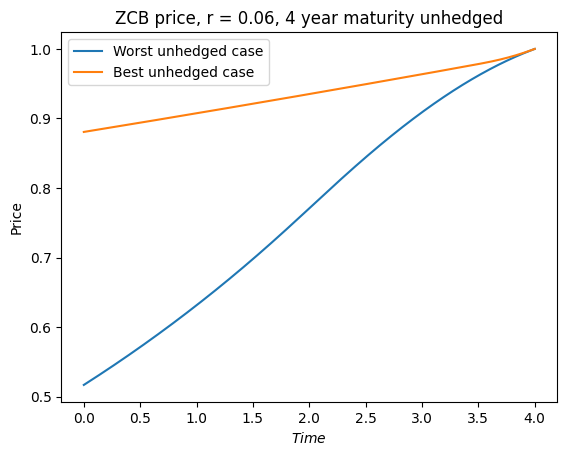

In [ ]:
plt.plot(np.linspace(0, 4, N+1), pde_solver(u_vec, c, 4)[18,:])
plt.plot(np.linspace(0, 4, N+1), pde_solver(u_vec, c, 4, worst = False)[18,:])

plt.xlabel("$Time$")
plt.ylabel("Price")
plt.title("ZCB price, r = 0.06, 4 year maturity unhedged")

plt.legend(["Worst unhedged case", "Best unhedged case"])
#plt.show()
plt.savefig('zcb_4y_unhedged.png')

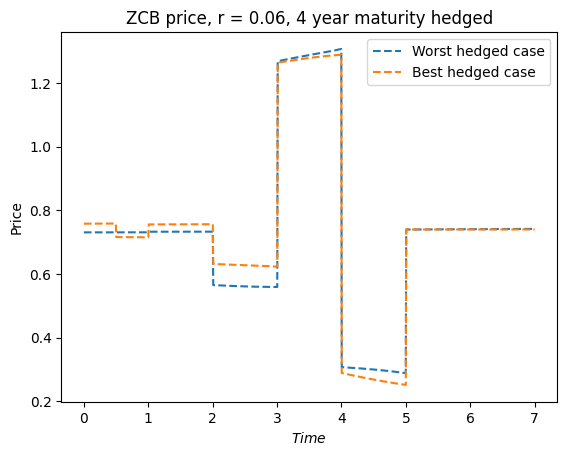

In [ ]:
# Result over time at a specified r say r = 0.06 --> at row 18
maturity_times = [0.5,1,2,3,5,7,4]
index_time = index_time_conv(maturity_times, T)[-1]

# plt.plot(np.linspace(0, 4, N+1), pde_solver(u_vec, c, 4)[18,:])
# plt.plot(np.linspace(0, 4, N+1), pde_solver(u_vec, c, 4, worst = False)[18,:])

plt.plot(t, pde_solver_hedge(u_vec, c, T=7,lambs = np.array([-1.859e-04, -1.831e-03,  1.678e-01, -7.092e-01, -4.513e-01
             , 1.080e-02]))[18,:]- np.dot(np.array([-1.859e-04, -1.831e-03,  1.678e-01, -7.092e-01, -4.513e-01
             , 1.080e-02]), market_prices)* np.ones(N+1), linestyle = '--')

plt.plot(t, pde_solver_hedge(u_vec, c, T=7,lambs = np.array([ 4.250e-02, -4.045e-02,  1.248e-01, -6.411e-01, -4.885e-01
            , -1.625e-09]), worst= False)[18,:]- np.dot(np.array([ 4.250e-02, -4.045e-02,  1.248e-01, -6.411e-01, -4.885e-01
            , -1.625e-09]), market_prices)* np.ones(N+1), linestyle = '--')

plt.xlabel("$Time$")
plt.ylabel("Price")
plt.title("ZCB price, r = 0.06, 4 year maturity hedged")

plt.legend(["Worst hedged case", "Best hedged case"])
#plt.show()
plt.savefig('zcb_4y_hedge.png')

# Liquidity modelling
Basically do the same pricing with one of the hedging instruments having bigger and bigger spreads.